# 使用电子密度图来作为特征

`StandardScaler()`  `X`

增加了一个dropout层，参数设为0.2，和keras中的相同

全部使用线性归一化，第一层的输出改为100

没有使用clearn

In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
#from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dos_para = pd.read_csv('../data/substituted_benzene_para_dos.csv',index_col=0,header=0)
dos_orth = pd.read_csv('../data/substituted_benzene_orth_dos.csv',index_col=0,header=0)
dos_meta = pd.read_csv('../data/substituted_benzene_meta_dos.csv',index_col=0,header=0)
dosdata = pd.concat([dos_meta,dos_orth,dos_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [3]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return temp

In [4]:
rawdataset = pd.merge(dosdata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

In [7]:
training_data = np.array(dataset,dtype=np.float64)

In [8]:
normalizer = Normalization(axis=-1)
normalizer.adapt(training_data)

normalized_data = normalizer(training_data)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: nan
mean: nan


In [5]:
Y = dataset.iloc[:, -1]
Y = np.array(Y, dtype = np.float64).reshape(-1,1)
Y = (Y - min(Y))/(max(Y) - min(Y))

In [7]:
X = dataset.iloc[:, 1:-1]
X = np.array(X, dtype = np.float64)
#np.seterr(divide='ignore', invalid='ignore')
X= StandardScaler().fit_transform(X)

d:\Miniconda3\envs\ai\lib\site-packages\sklearn\utils\extmath.py:847: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
d:\Miniconda3\envs\ai\lib\site-packages\sklearn\utils\extmath.py:689: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 100, input_dim = X.shape[1], activation='relu'))
model.add(Activation("sigmoid"))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300000    
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 300,101
Trainable params: 300,101
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32,validation_data = (X_test, y_test),verbose=1)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Epoch 1/50
9/9 [==============================] - 1s 43ms/step - loss: 0.0548 - accuracy: 0.0011 - val_loss: 0.0310 - val_accuracy: 0.0000e+00
Epoch 2/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0269 - accuracy: 0.0035 - val_loss: 0.0303 - val_accuracy: 0.0000e+00
Epoch 3/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0205 - accuracy: 7.4074e-04 - val_loss: 0.0336 - val_accuracy: 0.0000e+00
Epoch 4/50
9/9 [==============================] - 0s 11ms/step - loss: 0.0227 - accuracy: 0.0092 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 0.0216 - accuracy: 7.4074e-04 - val_loss: 0.0309 - val_accuracy: 0.0000e+00
Epoch 6/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0184 - accuracy: 0.0092 - val_loss: 0.0309 - val_accuracy: 0.0000e+00
Epoch 7/50
9/9 [==============================] - 0s 12ms/step - loss: 0.0223 - accuracy: 0.0092 - val_loss: 0.0305 - val_accuracy: 0.

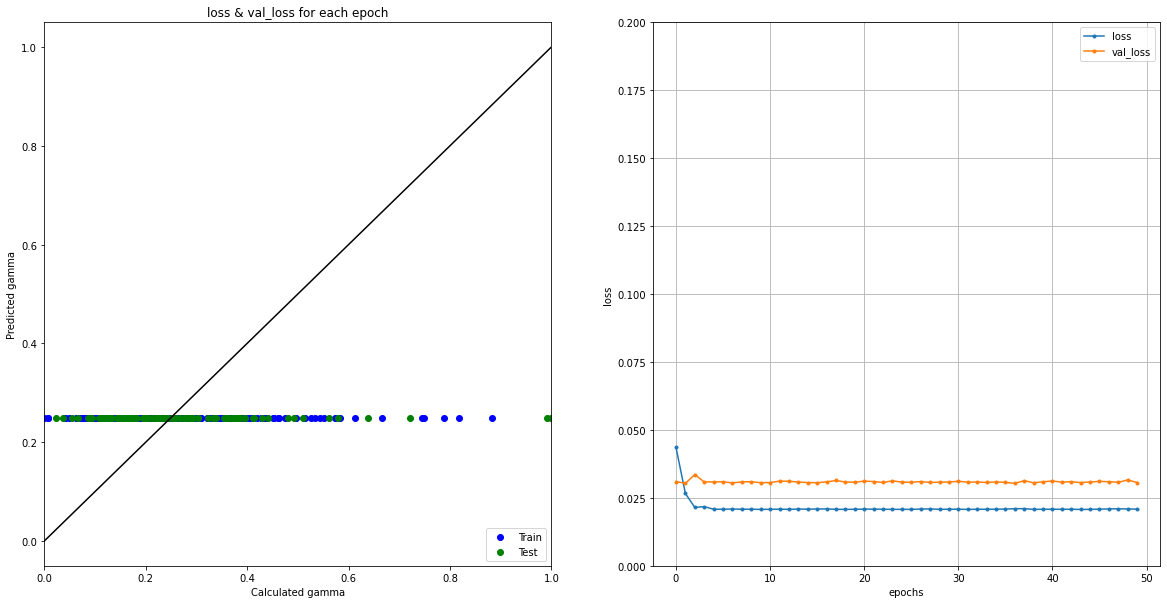

In [10]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
ax1.scatter(y_test, model.predict(X_test),c='green', label = 'Test', alpha = None)
ax1.plot([0,1],[0,1],c = 'k')
ax1.legend(loc = 4)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)

ax2 = fig.add_subplot(122)
ax1.set_title('loss & val_loss for each epoch')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.set_ylim(0,0.2)
ax2.plot(range(epochs), loss, marker = '.', label = 'loss')
ax2.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best')
ax2.grid()

plt.show()

## Conclusion

完全失败，可能是梯度爆炸，包含了太多的零了